In [ ]:
# !pip install -r requirements.txt

## Import LENs

In [2]:
import torch

In [7]:
import lens
# Hardly modified to work

## Create train, validation and test datasets
Let's create a XOR-like datasets with 2 redundant features (the 3rd and 4th).

In [8]:
lens.utils.base.set_seed(0)
x = torch.rand([100, 4])
y = (x[:, 0] > 0.5) & (x[:, 1] < 0.5) | \
    (x[:, 0] < 0.5) & (x[:, 1] > 0.5)

data = torch.utils.data.TensorDataset(x, y)

train_data, val_data, test_data = torch.utils.data.random_split(data, [80, 10, 10])
x_train, y_train = data[train_data.indices]
x_val, y_val = data[val_data.indices]
x_test, y_test = data[test_data.indices]

### Hardcore mode
Let's see what is returned when the dataset is made with errors on purpose.

In [37]:
lens.utils.base.set_seed(0)
x = torch.rand([100, 4])
y = (x[:, 0] > 0.5) & (x[:, 1] < 0.5) | \
    (x[:, 0] < 0.5) & (x[:, 1] > 0.5)

# Change 50 results
for i in range(50):
  y[i] = not y[i] # UPSI
y

data = torch.utils.data.TensorDataset(x, y)

train_data, val_data, test_data = torch.utils.data.random_split(data, [80, 10, 10])
x_train, y_train = data[train_data.indices]
x_val, y_val = data[val_data.indices]
x_test, y_test = data[test_data.indices]

With those results, as we should expect, a new explanation is given.

## Instantiate a XMuNN
X for eXplainable.

In [38]:
model = lens.models.XMuNN(n_classes=2, 
                          n_features=4,
                          hidden_neurons=[10], 
                          loss=torch.nn.CrossEntropyLoss())

## Train the model

In [39]:
model.fit(train_data, val_data, 
          epochs=100, l_r=0.1)

Epoch: 1/100, Loss: 0.715, Tr_acc: 38.75, Val_acc: 40.00, best_e: -1
Epoch: 2/100, Loss: 0.762, Tr_acc: 56.25, Val_acc: 40.00, best_e: -1
Epoch: 3/100, Loss: 0.689, Tr_acc: 56.25, Val_acc: 30.00, best_e: -1
Epoch: 4/100, Loss: 0.688, Tr_acc: 60.00, Val_acc: 30.00, best_e: -1
Epoch: 5/100, Loss: 0.684, Tr_acc: 57.50, Val_acc: 40.00, best_e: -1
Epoch: 6/100, Loss: 0.671, Tr_acc: 57.50, Val_acc: 30.00, best_e: -1
Epoch: 7/100, Loss: 0.663, Tr_acc: 61.25, Val_acc: 30.00, best_e: -1
Epoch: 8/100, Loss: 0.659, Tr_acc: 62.50, Val_acc: 40.00, best_e: -1
Epoch: 9/100, Loss: 0.652, Tr_acc: 61.25, Val_acc: 20.00, best_e: -1
Epoch: 10/100, Loss: 0.651, Tr_acc: 55.00, Val_acc: 30.00, best_e: -1
Epoch: 11/100, Loss: 0.644, Tr_acc: 56.25, Val_acc: 40.00, best_e: -1
Epoch: 12/100, Loss: 0.646, Tr_acc: 60.00, Val_acc: 40.00, best_e: -1
Epoch: 13/100, Loss: 0.640, Tr_acc: 61.25, Val_acc: 20.00, best_e: -1
Epoch: 14/100, Loss: 0.641, Tr_acc: 58.75, Val_acc: 30.00, best_e: -1
Epoch: 15/100, Loss: 0.638, T

c:\Users\rodga\Documentos\Escritorio\logic_explained_networks\lens\models\base.py:348: UserWarning: Loaded model does not have time or explanations. They need to be recalculated but time will only consider rule extraction time.
  warnings.warn("Loaded model does not have time or explanations. "


,Tot losses,Train accs,Val accs,Best epoch
0,0.714975,38.75,40.0,96
1,0.761772,56.25,40.0,96
2,0.689471,56.25,30.0,96
3,0.687749,60.00,30.0,96
4,0.684423,57.50,40.0,96
...,...,...,...,...
95,0.552953,73.75,60.0,96
96,0.552154,75.00,50.0,96
97,0.549757,75.00,50.0,96
98,0.549234,75.00,50.0,96


In [40]:
## get accuracy on test samples
test_acc = model.evaluate(test_data)
print("Test accuracy:", test_acc)

Test accuracy: 50.0


## Extract and evaluate global explanation

In [41]:
## get first order logic explanations for a specific target class
target_class = 1
concept_names = ['x1', 'x2', 'x3', 'x4']

formula = model.get_global_explanation(x_train, y_train, target_class,
                                       top_k_explanations=2, 
                                       concept_names=concept_names)
print(f"{formula} <-> f{target_class}")

(x1 & x4 & ~x3) | (~x1 & ~x3 & ~x4) <-> f1


In [17]:
## compute explanation accuracy
exp_accuracy, _ = lens.logic.test_explanation(formula, target_class, x_test, y_test,
                                              concept_names=concept_names)
print("Logic Test Accuracy:", exp_accuracy)

Logic Test Accuracy: 100.0


## Plot decision boundaries and explanations

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_bundaries(model, x, h=0.1, cmap='BrBG'):
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                           np.arange(x2_min, x2_max, h))
    xx = torch.FloatTensor(np.c_[xx1.ravel(), xx2.ravel(), xx1.ravel(), xx2.ravel()])
    Z = model(xx).argmax(dim=1).detach().numpy()
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    return


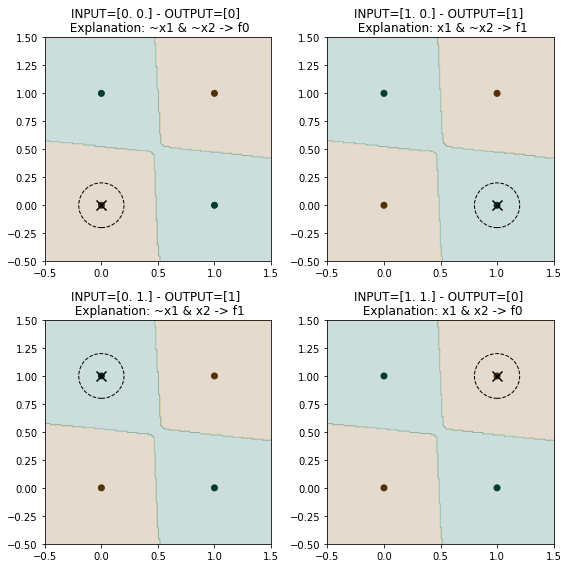

In [13]:
x = torch.as_tensor([[0.0, 0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0, 0.0],
                     [1.0, 1.0, 0.0, 0.0]])
y = torch.as_tensor([0, 1, 1, 0])
cmap = 'BrBG'
plt.figure(figsize=[8, 8])
for sample_id, (xin, yin) in enumerate(zip(x, y)):
    output = model(xin.unsqueeze(dim=0))
    explanation = model.get_local_explanation(x_train, y_train, xin, yin,
                                              concept_names=concept_names)

    plt.subplot(2, 2, sample_id + 1)
    plt.title(f'INPUT={xin[:2].detach().numpy()} - OUTPUT={output.argmax(dim=1).detach().numpy()} '
              f'\n Explanation: {explanation} -> f{output.argmax()}')
    plot_decision_bundaries(model, x, h=0.01)
    plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), c=y.detach().numpy(), cmap=cmap)
    plt.scatter(xin[0], xin[1], c='k', marker='x', s=100, cmap=cmap)
    c = plt.Circle((xin[0], xin[1]), radius=0.2, edgecolor='k', fill=False, linestyle='--')
    plt.gca().add_artist(c)
    plt.xlim([-0.5, 1.5])
    plt.ylim([-0.5, 1.5])
plt.tight_layout()
plt.show()